# Exp 16. 다음에 볼 영화 예측하기

* `Movielens 1M Dataset`을 기반으로 Session based Recommendation 시스템을 제작해보자.

---

# 🗼 목차
Step 0. 라이브러리 불러오기  
Step 1. 데이터 불러오기  
Step 2. 데이터 전처리  
Step 3. 미니 배치의 구성  
Step 4. 모델 구성  
Step 5. 모델 학습  
Step 6. 모델 테스트  
Step 7. 모델 개선 (하이퍼파라미터 변경)  
🌞 회고

---

# Step 0. 라이브러리 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import tensorflow

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# print(pandas.__version__)
# print(tensorflow.__version__)

---

# Step 1. 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [4]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
original_data_size = len(data)

data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


* 추천 시스템을 구축할 때 가장 먼저 확인해볼 것은 유저수, 아이템 수이다.
* 해당 데이터의 유저 수는 6040개, 아이템 수는 3706개이다.

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

---

# Step 2. 데이터 전처리

## 2.1 Session Length
* `session length`는 같은 `userid`를 공유하는 데이터 row의 개수를 의미한다.
* 유저가 몇 개의 영화에 대한 평가를 하였는지를 나타낸다.

In [6]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

* `user_length`의 중앙값과 평균을 확인해보자.

In [7]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

* `session_length`의 최솟값과 최댓값을 확인해보자.

In [8]:
session_length.min(), session_length.max()

(20, 2314)

* `session_length`의 99%의 분위수를 확인해보자.

In [9]:
session_length.quantile(0.99)

906.659999999998

* 길이가 2314는 한 사람이 보기에 너무나 많은 양의 영화 갯수로 데이터를 확인해볼 필요가 있다.
* `Rating`이 같은 것도 아니고 `ItenId`도 같은 것들이 아니기에 `Time`을 확인해보아야 하는데 아래에서 확인을 해보고 제거할 지 판단을 해야 한다.

In [10]:
long_session = session_length[session_length == 2314].index[0]
data[data['UserId'] == long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


* `session_length`를 시각적으로 나타내기 위해 `session_length` 기준 하위 99%까지의 분포 누적합을 확인해보자.

In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()   # cumsum() : 누적합
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_99

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

* `session_length`를 시각화해보자.

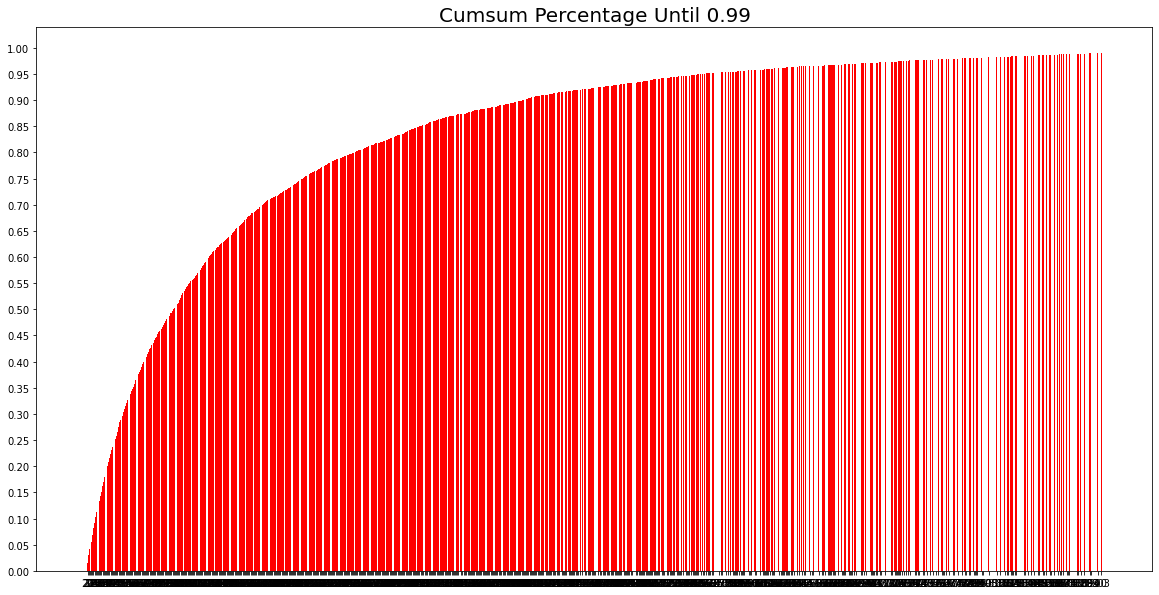

In [12]:
plt.figure(figsize=(20, 10))

plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

## 2.2 Time
* 해당 데이터의 ReadMe를 읽어보면 아래와 같은 Time에 대한 설명이 기재되어있다.
* Timestamp is represented in seconds since the epoch as returned by time(2)
* Time 데이터에는 유닉스 시간으로 1970년 1월 1일 00:00:00 협정 세계시(UTC)부터의 경과 시간을 초로 환산하여 정수로 나타낸 것이다.
* Timestamp로 지정된 시간 값을 특정 날짜 포맷으로 변경하는 작업을 진행해보자.  
    
[참고자료1_유닉스시간](https://ko.wikipedia.org/wiki/%EC%9C%A0%EB%8B%89%EC%8A%A4_%EC%8B%9C%EA%B0%84)  

[참고자료2_Timestamp를 특정 날짜 포맷으로 변경](https://webisfree.com/2019-01-23/python-%ED%83%80%EC%9E%84%EC%8A%A4%ED%83%AC%ED%94%84-%EC%8B%9C%EA%B0%84%EC%9D%84-%EB%85%84%EC%9B%94%EC%9D%BC%EB%A1%9C-%EB%B3%80%ED%99%98%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95)

In [13]:
import datetime

new_date = []
for i in data['Time']:
    new_time = datetime.datetime.fromtimestamp(i)
    new_date.append(new_time)
    
data['Time'] = new_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


* 2000년 4월부터 2003년 2월까지 대략 3년에 가까운 데이터가 있는 것을 확인하였다.

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [15]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

* 2.1에서 길이가 2314인 데이터의 Time을 변환한 데이터로 다시 확인해보았다.
* 동일한 날짜는 물론, 같은 시분초에 여러 개의 영화를 평가한 것으로 확인된다.

In [16]:
long_session = session_length[session_length == 2314].index[0]
data[data['UserId'] == long_session].head(50)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
696250,4169,3841,2,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59


* 따라서 해당 데이터는 물론이고 누적합 99% 이상인 데이터들도 이상치로 판단하고 제거한다.
* session_length의 99%의 분위수: 906.659999999998

In [17]:
drop_index = session_length[session_length>906].index
data.drop(index=drop_index, inplace=True)

* 데이터의 개수가 1000209개에서 1000148로 줄어들었다.

In [18]:
data.shape

(1000148, 4)

## 2.3 Rating (Data Cleansing)
* 유저가 별점을 3점 미만으로 준 데이터는 선호하지 않는다고 가정하여 `Rating`이 3점 이상인 데이터만 남기고 제거하였다.
* 별점 3점 이상의 데이터 크기는 `836,478`이며, 비율은 `83.63%`를 차지한다.

In [19]:
data = data[data['Rating'] >= 3]
filltered_data_size = len(data)

print(f'전체 데이터 크기 : {original_data_size}')
print(f'별점 3점 이상의 데이터 크기 : {filltered_data_size}')
print(f'별점 3점 이상의 데이터 비율 : {filltered_data_size / original_data_size : .2%}')

전체 데이터 크기 : 1000209
별점 3점 이상의 데이터 크기 : 836426
별점 3점 이상의 데이터 비율 :  83.63%


## 2.4 train / valid / test data Split
* 모델 평가를 위해 valid set과 test set을 만들어보자.
* test 데이터는 마지막 5개월 전까지, valid 데이터도 5개월 전까지로 설정하여 분리하였다.

In [20]:
from datetime import timedelta

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - datetime.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - datetime.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

In [21]:
tr, test = split_by_date(data, n_days = 150)

In [22]:
tr, val = split_by_date(tr, n_days = 150)

In [23]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t 데이터 개수: {len(data)}\n'
          f'\t User 고유 개수: {data["UserId"].nunique()}\n'
          f'\t Item 고유 개수: {data["ItemId"].nunique()}\n'
          f'\t 데이터 시작 시간 : {data["Time"].min()}\n'
          f'\t 데이터 종료 시간 : {data["Time"].max()}\n')

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 데이터 개수: 823296
	 User 고유 개수: 6038
	 Item 고유 개수: 3620
	 데이터 시작 시간 : 2000-04-25 23:05:32
	 데이터 종료 시간 : 2002-05-04 09:26:12

* valid Set Stats Info
	 데이터 개수: 6910
	 User 고유 개수: 326
	 Item 고유 개수: 2079
	 데이터 시작 시간 : 2002-05-04 21:11:01
	 데이터 종료 시간 : 2002-10-01 09:36:33

* test Set Stats Info
	 데이터 개수: 6220
	 User 고유 개수: 311
	 Item 고유 개수: 1919
	 데이터 시작 시간 : 2002-10-01 19:26:51
	 데이터 종료 시간 : 2003-02-28 17:49:50



* train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱한다.

In [25]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

* 준비한 데이터를 저장하자.

In [26]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

---

# Step 3. 미니 배치의 구성
* Session-Parallel Mini-Batch를 구현하여 학습 속도의 저하가 최소화될 수 있도록 구성해보자.

## 3.1 Session Dataset
* 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만들어보자.

In [27]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

* train 데이터로 `SessionDataset` 객체를 만들고 인스턴스 변수를 살펴보자.

In [28]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


* `click_offsets`변수는 각 세션이 시작된 인덱스를 담고 있다.

In [29]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 822901, 823020, 823296], dtype=int32)

* `session_idx` 변수는 각 세션을 인덱싱한 `np.array`이다.

In [30]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

## 3.2 Session Data Loader
* `SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만들어보자.
* `__iter__`매서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`한다.
* `mask`는 후에 RNN Cell State를 초기화하는데 사용한다.

In [31]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [33]:
iter_ex = iter(tr_data_loader)

* 아래 셀을 반복 실행하면 `next`가 계속 다음 데이터를 만든다.

In [34]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


---

# Step 4. 모델 구성

## 4.1 Evaluation Metrix
* 모델 성능 평가를 위한 지표를 확인해보자.
* `MRR`과 `Recall@k`를 사용해보자.

### MRR(Mean Reciprocal Rank)
- 우선순위를 고려한 평가기준 중 가장 간단한 모델이다.
- 순서에 민감한 지표로, 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이다.
- 각 사용자마다 제공한 추천 컨텐츠 중 관련있는 컨텐츠 중 가장 높은 위치를 역수로 계산(1/k)하고 사용자마다 계산된 점수를 모아 평균을 계산한다.  

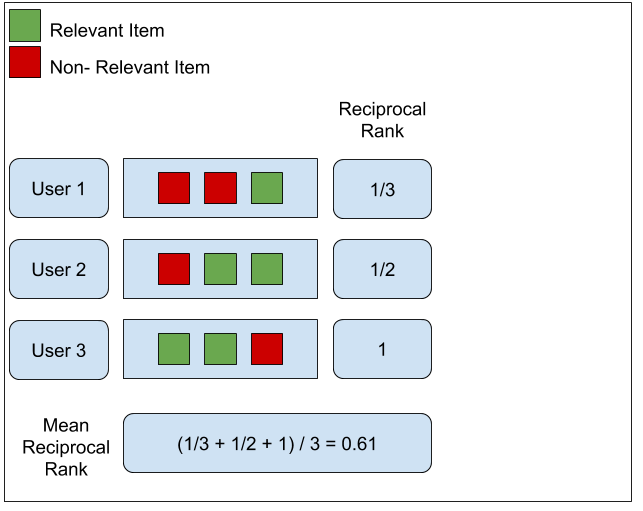  

[MRR 참고 자료](https://lamttic.github.io/2020/03/20/01.html)

### Recall@k
- recall 개념을 확장한 지표
- 사용자가 관심있는 모든 아이템 중에서 내가 추천한 아이템 K개가 얼마나 포함되는지 비율을 의미한다.
- K는 추천 아이템 수를 의미한다.  

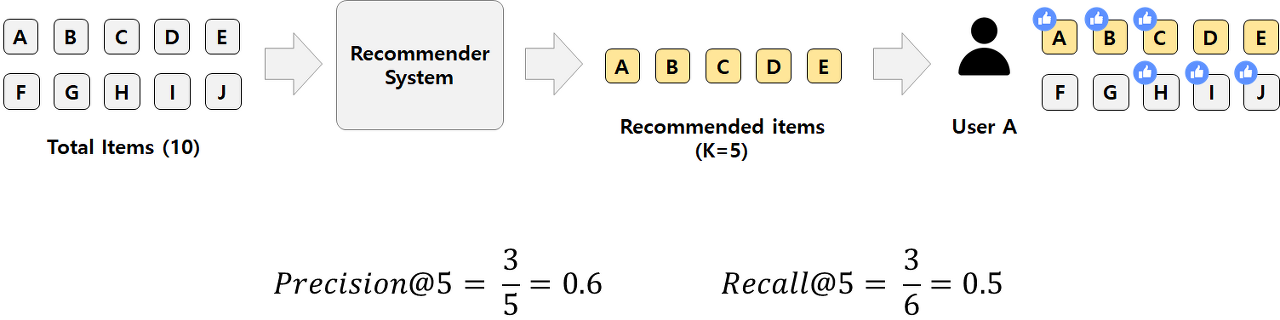  
    
[Recall@k 참고자료](https://sungkee-book.tistory.com/11)

In [35]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 4.2 Model Architecture

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [37]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

* 모델에 사용할 하이퍼파라미터를 class 형식으로 관리해보자.

In [38]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [39]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3620)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550800    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3620)               184620    
Total params: 735,420
Trainable params: 735,420
Non-trainable params: 0
_________________________________________________________________


---

# Step 5. 모델 학습

In [41]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [42]:
train_model(model, args)

Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.36it/s]


	 - Recall@20 epoch 1: 0.087891
	 - MRR@20    epoch 1: 0.018676



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.41it/s]


	 - Recall@20 epoch 2: 0.105859
	 - MRR@20    epoch 2: 0.027585



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.41it/s]

	 - Recall@20 epoch 3: 0.113281
	 - MRR@20    epoch 3: 0.031224



---

# Step 6. 모델 테스트
* 지금까지 작성한 모델이 테스트셋에 대해서 어느정도 성능을 내는지 검증해보자.

In [43]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  33%|███▎      | 15/46 [00:10<00:22,  1.40it/s]

	 - Recall@20: 0.136458
	 - MRR@20: 0.038581



---

# Step 7. 모델 개선 (하이퍼파라미터 변경)

## 7.1 epoch 3 → 10 변경
* 확실히 epoch를 늘리니 미세하지만 성능이 좋아지는 것을 확인할 수 있다.

In [44]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [45]:
train_model(model, args)

Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.42it/s]


	 - Recall@20 epoch 1: 0.119531
	 - MRR@20    epoch 1: 0.034030



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.41it/s]


	 - Recall@20 epoch 2: 0.121875
	 - MRR@20    epoch 2: 0.035342



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.43it/s]


	 - Recall@20 epoch 3: 0.121484
	 - MRR@20    epoch 3: 0.036599



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.45it/s]


	 - Recall@20 epoch 4: 0.123828
	 - MRR@20    epoch 4: 0.038093



Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.40it/s]


	 - Recall@20 epoch 5: 0.122656
	 - MRR@20    epoch 5: 0.038161



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.41it/s]


	 - Recall@20 epoch 6: 0.120703
	 - MRR@20    epoch 6: 0.038389



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.41it/s]


	 - Recall@20 epoch 7: 0.122266
	 - MRR@20    epoch 7: 0.039385



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.41it/s]


	 - Recall@20 epoch 8: 0.121875
	 - MRR@20    epoch 8: 0.039303



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.46it/s]


	 - Recall@20 epoch 9: 0.125391
	 - MRR@20    epoch 9: 0.039479



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.46it/s]

	 - Recall@20 epoch 10: 0.125000
	 - MRR@20    epoch 10: 0.039656



In [46]:
test_model(model, args, test)

Evaluation:  33%|███▎      | 15/46 [00:10<00:21,  1.42it/s]

	 - Recall@20: 0.151042
	 - MRR@20: 0.049617



## 7.2 learning rate 0.001 → 0.01
* `learning rate`를 0.01로 변경하였으나 결과는 0.001이 더 좋은 것을 확인할 수 있다.

In [47]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)

In [48]:
train_model(model, args)

Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.42it/s]


	 - Recall@20 epoch 1: 0.126172
	 - MRR@20    epoch 1: 0.040275



Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.38it/s]


	 - Recall@20 epoch 2: 0.122656
	 - MRR@20    epoch 2: 0.039394



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.42it/s]


	 - Recall@20 epoch 3: 0.123047
	 - MRR@20    epoch 3: 0.039670



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.42it/s]


	 - Recall@20 epoch 4: 0.123828
	 - MRR@20    epoch 4: 0.038650



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.43it/s]


	 - Recall@20 epoch 5: 0.129297
	 - MRR@20    epoch 5: 0.039271



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.44it/s]


	 - Recall@20 epoch 6: 0.126172
	 - MRR@20    epoch 6: 0.039102



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.43it/s]


	 - Recall@20 epoch 7: 0.130469
	 - MRR@20    epoch 7: 0.039763



Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.39it/s]


	 - Recall@20 epoch 8: 0.128516
	 - MRR@20    epoch 8: 0.039145



Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.40it/s]


	 - Recall@20 epoch 9: 0.131250
	 - MRR@20    epoch 9: 0.040044



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.41it/s]

	 - Recall@20 epoch 10: 0.130078
	 - MRR@20    epoch 10: 0.039079



In [49]:
test_model(model, args, test)

Evaluation:  33%|███▎      | 15/46 [00:10<00:22,  1.38it/s]

	 - Recall@20: 0.150000
	 - MRR@20: 0.047665



## 7.3  learning rate 0.001 → 0.0001

In [66]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.0001, epochs=10, k=20)

In [67]:
train_model(model, args)

Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.47it/s]


	 - Recall@20 epoch 1: 0.125000
	 - MRR@20    epoch 1: 0.038283



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.46it/s]


	 - Recall@20 epoch 2: 0.125391
	 - MRR@20    epoch 2: 0.038987



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.45it/s]


	 - Recall@20 epoch 3: 0.126562
	 - MRR@20    epoch 3: 0.038735



Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.38it/s]


	 - Recall@20 epoch 4: 0.124219
	 - MRR@20    epoch 4: 0.038163



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.46it/s]


	 - Recall@20 epoch 5: 0.125391
	 - MRR@20    epoch 5: 0.038469



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.44it/s]


	 - Recall@20 epoch 6: 0.126562
	 - MRR@20    epoch 6: 0.038902



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.43it/s]


	 - Recall@20 epoch 7: 0.125391
	 - MRR@20    epoch 7: 0.038432



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.45it/s]


	 - Recall@20 epoch 8: 0.124609
	 - MRR@20    epoch 8: 0.037523



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.44it/s]


	 - Recall@20 epoch 9: 0.125000
	 - MRR@20    epoch 9: 0.038378



Evaluation:  39%|███▉      | 20/51 [00:15<00:23,  1.32it/s]

	 - Recall@20 epoch 10: 0.125391
	 - MRR@20    epoch 10: 0.038714



In [68]:
test_model(model, args, test)

Evaluation:  33%|███▎      | 15/46 [00:10<00:22,  1.37it/s]

	 - Recall@20: 0.142187
	 - MRR@20: 0.048241



## 7.4 drop rate 0.1 → 0.5 변경
* 위에서 learning rate를 변경하여 성능을 확인하였지만, 변경하지 않은 것이 더 성능이 나아 다시 learning rate를 0.001로 변경하여 진행한다.

In [50]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.5, lr=0.001, epochs=10, k=20)

In [51]:
train_model(model, args)

Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.44it/s]


	 - Recall@20 epoch 1: 0.132422
	 - MRR@20    epoch 1: 0.038836



Evaluation:  39%|███▉      | 20/51 [00:14<00:21,  1.42it/s]


	 - Recall@20 epoch 2: 0.126172
	 - MRR@20    epoch 2: 0.039333



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.44it/s]


	 - Recall@20 epoch 3: 0.128516
	 - MRR@20    epoch 3: 0.038893



Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.38it/s]


	 - Recall@20 epoch 4: 0.129688
	 - MRR@20    epoch 4: 0.039206



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.44it/s]


	 - Recall@20 epoch 5: 0.127344
	 - MRR@20    epoch 5: 0.038613



Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.40it/s]


	 - Recall@20 epoch 6: 0.128906
	 - MRR@20    epoch 6: 0.038765



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.43it/s]


	 - Recall@20 epoch 7: 0.128516
	 - MRR@20    epoch 7: 0.038798



Evaluation:  39%|███▉      | 20/51 [00:14<00:22,  1.41it/s]


	 - Recall@20 epoch 8: 0.128906
	 - MRR@20    epoch 8: 0.037989



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.43it/s]


	 - Recall@20 epoch 9: 0.125000
	 - MRR@20    epoch 9: 0.036959



Evaluation:  39%|███▉      | 20/51 [00:13<00:21,  1.44it/s]

	 - Recall@20 epoch 10: 0.125781
	 - MRR@20    epoch 10: 0.037774



In [52]:
test_model(model, args, test)

Evaluation:  33%|███▎      | 15/46 [00:11<00:23,  1.31it/s]

	 - Recall@20: 0.143229
	 - MRR@20: 0.047208



### 하이퍼파라미터 변경 결과
1. 변경 전 (batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)  
    → Recall@20: 0.136458 /  MRR@20: 0.038581  
    
    
    
2. 에포크 변경 (batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)  
    → Recall@20: 0.151042 / MRR@20: 0.049617  
    
    
    
3. learning rate 변경 (batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)  
    → Recall@20: 0.150000 / MRR@20: 0.047665  
    

4. learning rate 변경 2 (batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20) 
    → Recall@20: 0.142187 / MRR@20: 0.048241  
    
    
5. drop rate 변경 ( batch_size=128, hsz=50, drop_rate=0.5, lr=0.001, epochs=10, k=20)  
    → Recall@20: 0.143229 /  MRR@20: 0.047208  
    
    
▶▶ learning rate, drop rate를 변경하였지만 성능이 저하되어 에포크만 10으로 변경하여 진행하는 것이 성능 향상에 도움이 된다고 판단된다.

---

# 🌞 회고


## 1) Session Id 정의
* `UserId`를 Session Id로 정의하고 프로젝트를 진행하였다.
* 프로젝트 진행 후 우수 프로젝트 코드를 참고하는데, `UserId`와 `Time` 기준으로 Session Id를 정의한 코드가 있어서 이러한 방법으로 Session Id를 정의하여 진행하여 비교해보는 것이 좋겠다고 생각이 들어 진행을 해보았다.
* 가장 좋은 성능을 나타내었던 하이퍼파라미터로 동일하게 하여 모델 학습을 하였다.
* 그 결과 `Recall@20: 0.247396 / MRR@20: 0.090361`이 나왔다.

### [다른 기준으로 Session Id 정의한 코드](https://github.com/aramssong/aiffel/blob/main/E-16/%5BE-16%5D%20Movielens_SBR_2.ipynb) 

## 2) 결과
- batch_size를 LMS에 있는 그대로 2048로 하였을 때, 훈련 시 index가 out of bound 되었다는 IndexError가 발생하였다.
- 그래서 batch_size를 확 낮추어 128로 진행하였다.
- 해당 파일에서 진행한 프로젝트(첫 파일)의 가장 좋았던 성능은 `Recall@20: 0.151042 / MRR@20: 0.049617`이었다.
    
    
- Session Id를 어떻게 정의하느냐에 따라 결과가 크게 차이나는 것을 알게 되었다.
- 단순히 `UserId`로만 정의하는 것이 아닌 `UserId`와 `Time`을 함께 기준으로 잡고 Session Id를 정의하였을 때 결과가 크게 향상된 것을 확인할 수 있었다.

## 3) 느낀 점

- 역시 추천시스템은 재밌다. 모처럼 재미있게 프로젝트를 한 것 같다.
- 그리고 지난 번 익스에서 활용했던 데이터라 익숙해서 나름 편하게 프로젝트를 할 수 있었다.
- 추천 시스템 쪽으로 더 공부해보고 싶었던 프로젝트였다.
- `UserId`로만 Session Id를 정의한 것 말고도 `UserId`와 `Time`을 함께 기준으로 잡고 정의한 것도 직접 해보고 성능을 비교할 수 있어서 좋았다.
- 역시 우수 프로젝트는 다르고,, 아직도 여전히 내가 부족하다는 것을 또 한번 느끼게 되었다...!😂

## 4) 기록용 참고 자료
* 우연히 보게 된 게시글들인데 나중에 다시 봐도 좋을 것 같아서 자료 기록한다!
- SBR 관련 게시글 : https://lsjsj92.tistory.com/590
- 홈쇼핑모아에서 만드는 AI 기반 상품 추천 시스템 : https://www.comworld.co.kr/news/articleView.html?idxno=50160